In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import logging
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Optional

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#!unzip Horne2017_FakeNewsData.zip

In [ ]:
class Pipeline:
    _DIVERSITY_KEYS = ['div_FUNC_sum',
  'div_LEX_percent',
  'div_VERB_sum',
  'div_FUNC_percent',
  'div_CONT_percent',
  'div_ADV_percent',
  'div_NOUN_percent',
  'div_VERB_percent',
  'div_ADJ_percent']
    _PRONOUN_KEYS = ['pron_FPP_sum', 'pron_FPS_sum']
    _QUANTITY_KEYS = ['quant_PRP$_sum',
  'quant_PUNCT_percent',
  'quant_PUNCT_sum',
  'quant_NEG_sum',
  'quant_UP_sum',
  'quant_UP_percent',
  'quant_VBD_percent',
  'quant_VBD_sum',
  'quant_NUM_sum',
  'quant_WDT_sum',
  'quant_QUOTE_sum',
  'quant_NEG_percent']
    _SENTIMENT_KEYS = ['senti_!_percent', 'senti_CAPS_sum', 'senti_?_sum']
    _AVERAGE_KEYS = ['avg_puncts_per_sent_sum']
    _MEDIAN_SYNTAX_TREE_KEYS = []
    _READABILITY_KEYS = []

    @dataclass
    class NonLatentConfig:
        diversity: bool = True
        pronoun: bool = True
        quantity: bool = True
        sentiment: bool = True
        average: bool = True
        # not include below
        median_syntax_tree: bool = False
        readability: bool = False

        def build_keys(self):
            keys = []
            if self.diversity:
                keys.extend(Pipeline._DIVERSITY_KEYS)
            if self.pronoun:
                keys.extend(Pipeline._PRONOUN_KEYS)
            if self.quantity:
                keys.extend(Pipeline._QUANTITY_KEYS)
            if self.sentiment:
                keys.extend(Pipeline._SENTIMENT_KEYS)
            if self.average:
                keys.extend(Pipeline._AVERAGE_KEYS)
            if self.median_syntax_tree:
                keys.extend(Pipeline._MEDIAN_SYNTAX_TREE_KEYS)
            if self.readability:
                keys.extend(Pipeline._READABILITY_KEYS)
            return keys

        def build_drop_keys(self):
            keys = []
            if not self.diversity:
                keys.extend(Pipeline._DIVERSITY_KEYS)
            if not self.pronoun:
                keys.extend(Pipeline._PRONOUN_KEYS)
            if not self.quantity:
                keys.extend(Pipeline._QUANTITY_KEYS)
            if not self.sentiment:
                keys.extend(Pipeline._SENTIMENT_KEYS)
            if not self.average:
                keys.extend(Pipeline._AVERAGE_KEYS)
            if not self.median_syntax_tree:
                keys.extend(Pipeline._MEDIAN_SYNTAX_TREE_KEYS)
            if not self.readability:
                keys.extend(Pipeline._READABILITY_KEYS)
            return keys

    def __init__(self, similarity=True, non_latent: Optional[NonLatentConfig]=NonLatentConfig()):
        self.similarity = similarity
        self.non_latent = non_latent

    def load_dataset_from_file(self):
        sets = {}
        for name in ["train", "valid", "test"]:
            df = pd.read_csv(f"features_{name}.csv")
            y = df["label"].to_numpy()
            labels_to_drop = ["label"]
            if not self.similarity:
                labels_to_drop.append("tf_idf_1_2_harmonic_mean")
            if self.non_latent:
                labels_to_drop.extend(self.non_latent.build_drop_keys())
            else:
                # Delete all keys
                labels_to_drop.extend(Pipeline.NonLatentConfig().build_keys())
            X = df.drop(labels_to_drop, axis=1).to_numpy()
            sets[name] = (X, y)
        X_train, y_train = sets["train"]
        X_valid, y_valid = sets["valid"]
        X_test, y_test = sets["test"]
        return (X_train, X_valid, X_test, y_train.astype(int), y_valid.astype(int), y_test.astype(int))

In [ ]:
pipeline = Pipeline(similarity=False)
X_train, X_valid, X_test, y_train, y_valid, y_test = pipeline.load_dataset_from_file()
input_shape = X_train.shape[1]

In [ ]:
input_shape

795

In [ ]:
model = tf.keras.models.Sequential([
    # DNN layers
    tf.keras.layers.Dense(input_shape, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2)
])

In [ ]:
from tensorflow.python.training.saver import metrics
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [ ]:
NUM_EPOCHS = 150

history = model.fit(
      x = X_train,
      y = y_train,
      epochs = NUM_EPOCHS,
      batch_size=16,
      verbose = 1,
      validation_data=(X_valid, y_valid))

Epoch 1/150
4/4 [==============================] - 2s 80ms/step - loss: 5.5729 - accuracy: 0.5263 - val_loss: 0.5794 - val_accuracy: 0.6000
Epoch 2/150
4/4 [==============================] - 0s 20ms/step - loss: 2.5783 - accuracy: 0.6316 - val_loss: 0.7184 - val_accuracy: 0.6000
Epoch 3/150
4/4 [==============================] - 0s 19ms/step - loss: 1.6672 - accuracy: 0.7544 - val_loss: 0.5271 - val_accuracy: 0.7500
Epoch 4/150
4/4 [==============================] - 0s 26ms/step - loss: 2.4072 - accuracy: 0.7544 - val_loss: 0.5473 - val_accuracy: 0.7500
Epoch 5/150
4/4 [==============================] - 0s 30ms/step - loss: 3.7578 - accuracy: 0.6491 - val_loss: 0.5913 - val_accuracy: 0.7500
Epoch 6/150
4/4 [==============================] - 0s 19ms/step - loss: 2.0714 - accuracy: 0.8070 - val_loss: 0.6488 - val_accuracy: 0.7000
Epoch 7/150
4/4 [==============================] - 0s 25ms/step - loss: 1.9272 - accuracy: 0.7895 - val_loss: 0.8266 - val_accuracy: 0.7000
Epoch 8/150
4/4 [===

In [ ]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 35ms/step - loss: 0.4795 - accuracy: 0.9000


[0.47951340675354004, 0.8999999761581421]

In [ ]:
predictions = []
for value in (model.predict(X_test)>=0.5).astype(int):
  predictions.append(value[0])
predictions = np.array(predictions)
actual = y_test

print(predictions)
print(actual)

1/1 [==============================] - 0s 83ms/step
[1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0]
[1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0]


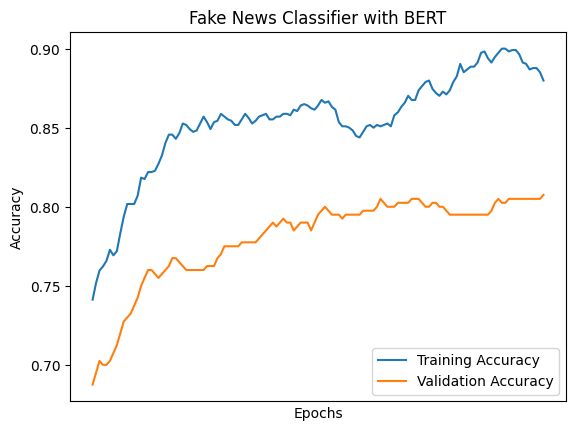

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

AVERAGING = 20

train_accs = history.history['accuracy']
train_graph = moving_average(train_accs, AVERAGING)
epoch_range = [x + 1 for x in range(len(train_graph))]

validation_accs = history.history['val_accuracy']
val_graph = moving_average(validation_accs, AVERAGING)
epoch_range = [x + 1 for x in range(len(val_graph))]

plt.plot(np.asarray(epoch_range).astype(str), train_graph, label='Training Accuracy')
plt.plot(np.asarray(epoch_range).astype(str), val_graph, label='Validation Accuracy')
plt.xticks([])
plt.title('Fake News Classifier with BERT')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
predictions = []
for value in (model.predict(X_test)>=0.5).astype(int):
  predictions.append(value[0])
predictions = np.array(predictions)
actual = y_test

print(classification_report(actual, predictions))

1/1 [==============================] - 0s 32ms/step
0.9090909090909091
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.91      0.91      0.91        11

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



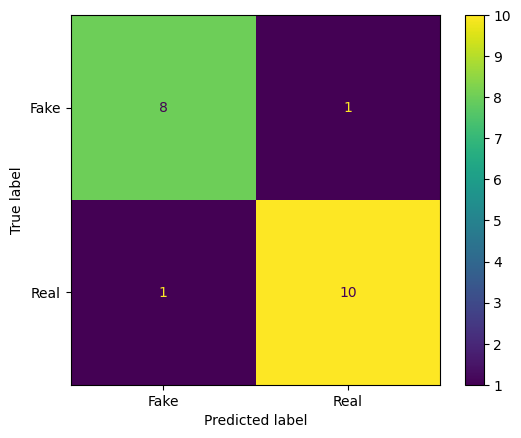

In [ ]:
# confusion matrix
cm = confusion_matrix(actual, predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot()
plt.show()

In [ ]:
#model.save("fake_news_classification_model")

In [ ]:
#!zip -r fake_news_classification_model.zip fake_news_classification_model

#from google.colab import files
#files.download("/content/fake_news_classification_model.zip")